# Deep Learning Project - Text Classification using CNN and RNN networks
## Text Classification on Twitter Emotion Dataset.
Name: Murari Prasad

Student ID: 24200412
- Using simple pattern learning network CNN
- Then trying sequence based using Bi-Directional RNN

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras_tuner as ktuner

import evalulation_functions as eval_functions  # Custom module with utility functions

2025-04-30 15:18:29.240729: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 15:18:29.539387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746022709.640460   15164 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746022709.672001   15164 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 15:18:29.936102: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Check for GPU and apply memory usage optimizations
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print("GPU available")

    # Set memory growth TRUE to allow dynamic memory allocation instead of pre-allocating GPU VRAM
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("No GPU")

GPU available


In [3]:
# Few constants
RANDOM_SEED = 2025
BATCH_SIZE = 256
MAX_TOKENS = 14  # words beyond this are being ignored, 90% data under 14 tokens (EDA file)

In [4]:
# Reading processed dataset - generated using data_handler.py
try:
    dataset = pd.read_parquet('glove-25-embedded-14token_0.parquet')
except:
    # download backup from google drive
    import gdown
    url = "https://drive.google.com/file/d/14sOdqE2tl_eXYR8Rj7Emn3mpNBY8Z0AL/view?usp=sharing"
    gdown.download(url, 'glove-25-embedded-14token_0.parquet', fuzzy=True)
    dataset = pd.read_parquet('glove-25-embedded-14token_0.parquet')

Downloading...
From (original): https://drive.google.com/uc?id=14sOdqE2tl_eXYR8Rj7Emn3mpNBY8Z0AL
From (redirected): https://drive.google.com/uc?id=14sOdqE2tl_eXYR8Rj7Emn3mpNBY8Z0AL&confirm=t&uuid=0da72436-59af-4cae-aabf-1dcc38120c53
To: /home/murarip/masters/deep_learning/projectFiles/project/glove-25-embedded-14token_0.parquet
100%|██████████| 904M/904M [00:12<00:00, 74.9MB/s] 


In [5]:
# Changing target variable from strings to integers
dataset['Emotion'] = dataset['Emotion'].replace({'disappointed': 0, 'happy': 1, 'angry': 2})

/tmp/ipykernel_15164/2059260980.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Emotion'] = dataset['Emotion'].replace({'disappointed': 0, 'happy': 1, 'angry': 2})


In [6]:
# Train-Validation-Test Split using Stratified Random Sampling
pd_train, pd_test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED, stratify=dataset['Emotion'], shuffle=True)
pd_train, pd_val = train_test_split(pd_train, test_size=0.1, random_state=RANDOM_SEED, stratify=pd_train['Emotion'], shuffle=True)

In [7]:
# Creating Tensors of the data
tf_train = tf.convert_to_tensor(pd_train['embedded_vector'].tolist(), dtype='float16')
tf_train_labels = tf.convert_to_tensor(pd_train['Emotion'])

tf_val = tf.convert_to_tensor(pd_val['embedded_vector'].tolist(), dtype='float16')
tf_val_labels = tf.convert_to_tensor(pd_val['Emotion'])

tf_test = tf.convert_to_tensor(pd_test['embedded_vector'].tolist(), dtype='float16')
tf_test_labels = tf.convert_to_tensor(pd_test['Emotion'])

I0000 00:00:1746022740.091267   15164 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-04-30 15:19:09.927686: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [8]:
# Create Tensorflow datasets and apply batching
raw_train = tf.data.Dataset.from_tensor_slices((tf_train, tf_train_labels))
raw_val = tf.data.Dataset.from_tensor_slices((tf_val, tf_val_labels))
raw_test = tf.data.Dataset.from_tensor_slices((tf_test, tf_test_labels))

train = raw_train.batch(BATCH_SIZE)
val = raw_val.batch(BATCH_SIZE)
test = raw_test.batch(BATCH_SIZE)


In [9]:
first_text_batch, first_label_batch = next(iter(train))
first_text = first_text_batch[0]
print("Record shape", first_text.shape)
print("Batch shape", first_text_batch.shape)

Record shape (14, 25)
Batch shape (256, 14, 25)


In [10]:
# Pre-fetching data and caching for faster training
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### 1. CNN Model Building

In [11]:
def build_cnn_model(hp):
    """
    NOTE: Some prelimnary trials were run for the choice of the parameter space used here.

    :param hp: HyperParameters instance
    :return: Compiled Keras model
    """
    # Hyperparameters
    hp_learning_rate = hp.Choice("learning_rate", values=[0.01, 0.001, 0.0001])
    activation = hp.Choice('activation', values=['gelu', 'swish', 'elu'])
    dropout_rate = hp.Choice("dropout_rate", values=[0.1, 0.2, 0.3])
    padding = hp.Choice('padding', values=['valid', 'same'])

    # filter size options (kernel_size)
    kernel_sizes = hp.Choice('kernel_sizes', values=["2,3,4", "3,4,5", "4,5,6"])
    kernel_sizes = [int(x) for x in kernel_sizes.split(',')]

    # Input layer
    inputs = tf.keras.Input(shape=(MAX_TOKENS, 25))

    # Conv1D Layers
    x_0 = tf.keras.layers.Conv1D(
        filters=hp.Int("filters_0", min_value=64, max_value=1024, step=32),
        kernel_size=kernel_sizes[0],
        strides=hp.Int("strides_0", min_value=1, max_value=3, step=1),
        activation=activation,
        padding=padding
    )(inputs)
    x_1 = tf.keras.layers.Conv1D(
        filters=hp.Int("filters_1", min_value=64, max_value=1024, step=32),
        kernel_size=kernel_sizes[1],
        strides=hp.Int("strides_1", min_value=1, max_value=3, step=1),
        activation=activation,
        padding=padding
    )(inputs)
    x_2 = tf.keras.layers.Conv1D(
        filters=hp.Int("filters_2", min_value=64, max_value=1024, step=32),
        kernel_size=kernel_sizes[2],
        strides=hp.Int("strides_2", min_value=1, max_value=3, step=1),
        activation=activation,
        padding=padding
    )(inputs)

    # MaxPool, same as kernel size
    x_0 = tf.keras.layers.MaxPooling1D(pool_size=kernel_sizes[0])(x_0)
    x_1 = tf.keras.layers.MaxPooling1D(pool_size=kernel_sizes[1])(x_1)
    x_2 = tf.keras.layers.MaxPooling1D(pool_size=kernel_sizes[2])(x_2)
    # Flatten
    x_0 = tf.keras.layers.Flatten()(x_0)
    x_1 = tf.keras.layers.Flatten()(x_1)
    x_2 = tf.keras.layers.Flatten()(x_2)

    # Concatenate
    x = tf.keras.layers.Concatenate()([x_0, x_1, x_2])
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

    # Output Layer
    outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

    # Build & Compile model
    hp_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    hp_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    return hp_model

In [12]:
# A Callback to stop tuner early if validation loss is not improving. Revert to the best val_loss weights when we stop.
# Separate for training, want more patience

# Tuner also needs the best weight restoration, because we train a few epochs and then we reject
# few models in Hyperband, so when we resume the next round, resuming from the best weights should be better overall\
stop_early_tuner = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
# Initialize Keras Tuner using Hyperband algorithm
# Delete old project from kerasTuner directory, or give new name, else tuner continues from last state
cnn_model_tuner = ktuner.Hyperband(
    build_cnn_model,
    objective=ktuner.Objective(name='val_accuracy', direction='max'),
    max_epochs=25,
    factor=3,                  # Reduction factor (no of models to drop and after how many epochs)
    directory='kerasTuner',
    project_name=f'CNN_approach',
    seed=RANDOM_SEED,
)

In [14]:
# Start tuner
cnn_model_tuner.search(train, validation_data=val, callbacks=[stop_early_tuner])

Trial 22 Complete [00h 01m 26s]
val_accuracy: 0.6339508295059204

Best val_accuracy So Far: 0.6810271739959717
Total elapsed time: 00h 07m 41s


In [15]:
# Let's see the network configuration obtained
cnn_model_tuner.get_best_models()[0].summary()

/home/murarip/miniconda3/envs/dl_project/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14, 25)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 4, 96)     │      7,296 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 11, 160)   │     16,160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 832)   │    104,832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 96)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 2, 160)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 2, 832)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 96)        │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 320)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1664)      │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2080)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2080)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │      6,243 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 134,531 (525.51 KB)

 Trainable params: 134,531 (525.51 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Let us see all the parameters searched by the tuner
cnn_model_best_hps=cnn_model_tuner.get_best_hyperparameters()[0]
cnn_model_best_hps.values

{'learning_rate': 0.001,
 'activation': 'gelu',
 'dropout_rate': 0.1,
 'padding': 'valid',
 'kernel_sizes': '3,4,5',
 'filters_0': 96,
 'strides_0': 3,
 'filters_1': 160,
 'strides_1': 1,
 'filters_2': 832,
 'strides_2': 1,
 'tuner/epochs': 9,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [17]:
# Build and train model using the best parameters from the tuner
cnn_model = cnn_model_tuner.hypermodel.build(cnn_model_best_hps)
cnn_history = cnn_model.fit(train, validation_data=val, epochs=100, callbacks=[stop_early])

Epoch 1/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5714 - loss: 0.8925 - val_accuracy: 0.6322 - val_loss: 0.7957
Epoch 2/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6415 - loss: 0.7814 - val_accuracy: 0.6531 - val_loss: 0.7601
Epoch 3/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6640 - loss: 0.7416 - val_accuracy: 0.6619 - val_loss: 0.7431
Epoch 4/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6782 - loss: 0.7166 - val_accuracy: 0.6678 - val_loss: 0.7337
Epoch 5/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6871 - loss: 0.6986 - val_accuracy: 0.6708 - val_loss: 0.7279
Epoch 6/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6937 - loss: 0.6847 - val_accuracy: 0.6752 - val_loss: 0.7256
Epoch 7/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7003 - loss: 0.6735 - val_accuracy: 0.6763 - val_loss: 0.7250
Epoch 8/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7053 - loss: 0

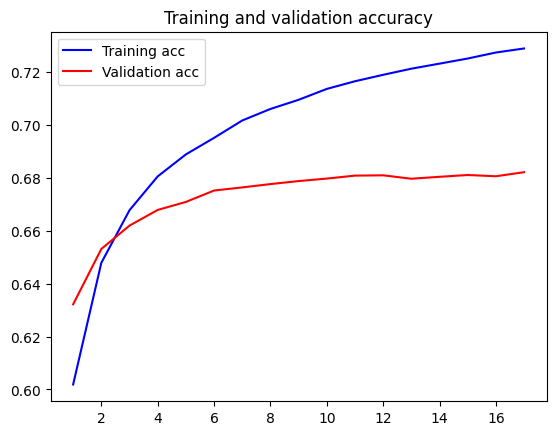

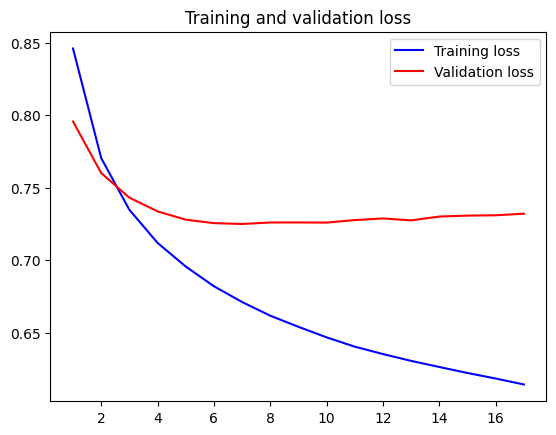

In [18]:
# plotting train and validation loss from history
eval_functions.plot_graphs_from_history(cnn_history)

In [19]:
# save model
cnn_model.save("cnn_model.keras")
cnn_model.save_weights("cnn_model.weights.h5")

In [20]:
# free resources
tf.keras.backend.clear_session()

#### 2. RNN Model Building

In [21]:
def build_rnn_model(hp):
    """
    NOTE: Some prelimnary trials were run for the choice of the parameter space used here.

    :param hp: HyperParameters instance
    :return: Compiled Keras model
    """
    # Hyperparameters
    hp_learning_rate = hp.Choice("learning_rate", values=[0.0001, 0.00001, 0.000001])
    activation = hp.Choice('activation', values=['gelu', 'swish', 'elu'])
    dropout_rate = hp.Choice("dropout_rate", values=[0.1, 0.2, 0.3])
    recurrent_dropout_rate = hp.Choice("recurrent_dropout_rate", values=[0.1, 0.2, 0.3])

    # Input layer
    inputs = tf.keras.Input(shape=(MAX_TOKENS, 25))

    # Bidirectional RNN Layers
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.SimpleRNN(
            units=hp.Int("rnn_units_0", min_value=64, max_value=1024, step=32),
            activation=activation,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout_rate,
            return_sequences=True
        )
    )(inputs)

    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.SimpleRNN(
            units=hp.Int("rnn_units_1", min_value=32, max_value=512, step=16),
            activation=activation,
            dropout=dropout_rate,
            recurrent_dropout=recurrent_dropout_rate
        )
    )(x)

    # Output Layer
    outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

    # Build and compile model
    hp_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    hp_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    return hp_model

In [22]:
# Initialize Keras Tuner using Hyperband algorithm
# Delete old project from kerasTuner directory, or give new name, else tuner continues from last state
rnn_model_tuner = ktuner.Hyperband(
    build_rnn_model,
    objective=ktuner.Objective(name='val_accuracy', direction='max'),
    max_epochs=25,
    factor=3,                  # Reduction factor (no of models to drop and after how many epochs)
    directory='kerasTuner',
    project_name=f'RNN_approach',
    seed=RANDOM_SEED,
)

In [23]:
# Start tuner
rnn_model_tuner.search(train, validation_data=val, callbacks=[stop_early_tuner])

Trial 30 Complete [00h 07m 12s]
val_accuracy: 0.5281965732574463

Best val_accuracy So Far: 0.7242728471755981
Total elapsed time: 02h 34m 14s


In [24]:
# Let's see the network configuration obtained
rnn_model_tuner.get_best_models()[0].summary()

/home/murarip/miniconda3/envs/dl_project/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 14, 1344)       │       938,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 480)            │       760,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,443 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,700,355 (6.49 MB)

 Trainable params: 1,700,355 (6.49 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Let us see all the parameters searched by the tuner
rnn_model_best_hps = rnn_model_tuner.get_best_hyperparameters()[0]
rnn_model_best_hps.values

{'learning_rate': 0.0001,
 'activation': 'gelu',
 'dropout_rate': 0.1,
 'recurrent_dropout_rate': 0.1,
 'rnn_units_0': 672,
 'rnn_units_1': 240,
 'tuner/epochs': 25,
 'tuner/initial_epoch': 9,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0023'}

In [26]:
# Build and train model using the best parameters from the tuner
rnn_model = rnn_model_tuner.hypermodel.build(rnn_model_best_hps)
rnn_history = rnn_model.fit(train, validation_data=val, epochs=100, callbacks=[stop_early])

Epoch 1/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.5295 - loss: 0.9462 - val_accuracy: 0.6179 - val_loss: 0.8043
Epoch 2/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.6125 - loss: 0.8159 - val_accuracy: 0.6562 - val_loss: 0.7370
Epoch 3/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.6439 - loss: 0.7589 - val_accuracy: 0.6763 - val_loss: 0.6937
Epoch 4/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.6654 - loss: 0.7191 - val_accuracy: 0.6894 - val_loss: 0.6651
Epoch 5/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.6779 - loss: 0.6918 - val_accuracy: 0.6969 - val_loss: 0.6494
Epoch 6/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.6871 - loss: 0.6719 - val_accuracy: 0.7028 - val_loss: 0.6386
Epoch 7/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.6956 - loss: 0.6565 - val_accuracy: 0.7048 - val_loss: 0.6310
Epoch 8/100
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 

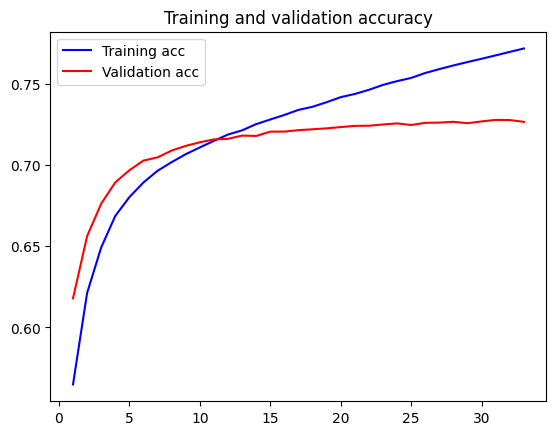

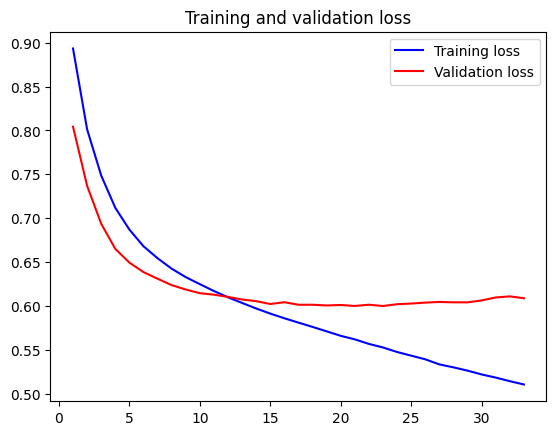

In [27]:
# plotting train and validation loss from history
eval_functions.plot_graphs_from_history(history=rnn_history)

In [28]:
# save model and weights
rnn_model.save("rnn_model.keras")
rnn_model.save_weights("rnn_model.weights.h5")

In [29]:
# free resources
tf.keras.backend.clear_session()

#### 3. Evaluation of both models

In [30]:
# Reading saved models from disk, or from google backups

try:
    cnn_model = tf.keras.models.load_model("cnn_model.keras")
except FileNotFoundError:
    import gdown
    url = "https://drive.google.com/file/d/1u3QAWiI0G9jnlxUIqTiAE3Hal9d6j2Qp/view?usp=sharing"
    gdown.download(url, 'cnn_model.keras', fuzzy=True)
    cnn_model = tf.keras.models.load_model("cnn_model.keras")

try:
    rnn_model = tf.keras.models.load_model("rnn_model.keras")
except FileNotFoundError:
    import gdown
    url = "https://drive.google.com/file/d/1yLi0b3JL5GW1blCHyYTmFk-hk2TFuf0U/view?usp=sharing"
    gdown.download(url, 'rnn_model.keras', fuzzy=True)
    rnn_model = tf.keras.models.load_model("rnn_model.keras")

Train Eval

In [32]:
actual, predicted = eval_functions.get_actual_predicted_labels(cnn_model, train)
precision, recall, f1_score, perf_metric = eval_functions.calculate_classification_metrics(actual, predicted, [0, 1, 2])
precision, recall, f1_score, perf_metric

   1/2570 ━━━━━━━━━━━━━━━━━━━━ 7:09 167ms/step

2025-04-30 18:26:20.399811: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2570/2570 ━━━━━━━━━━━━━━━━━━━━ 2s 901us/step


({0: 0.7188610557337263, 1: 0.7764005720700632, 2: 0.6850096757649026},
 {0: 0.7371967235701175, 1: 0.6972475797207529, 2: 0.737134535470466},
 {0: 0.7279134420646814, 1: 0.7346983323146772, 2: 0.710116857557094},
 {'avg_precision': 0.726757101189564,
  'avg_recall': 0.7238596129204454,
  'avg_f1_score': 0.7242428773121509})

In [33]:
actual, predicted = eval_functions.get_actual_predicted_labels(rnn_model, train)
precision, recall, f1_score, perf_metric = eval_functions.calculate_classification_metrics(actual, predicted, [0, 1, 2])
precision, recall, f1_score, perf_metric

2025-04-30 18:27:47.922240: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2570/2570 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


({0: 0.8004383451096551, 1: 0.7951143744704886, 2: 0.7594921188507282},
 {0: 0.775863218385696, 1: 0.8035879517739507, 2: 0.7756706366874443},
 {0: 0.7879592140719576, 1: 0.7993287069366187, 2: 0.7674961280330407},
 {'avg_precision': 0.7850149461436239,
  'avg_recall': 0.7850406022823636,
  'avg_f1_score': 0.7849280163472057})

Val eval

In [35]:
actual, predicted = eval_functions.get_actual_predicted_labels(cnn_model, val)
precision, recall, f1_score, perf_metric = eval_functions.calculate_classification_metrics(actual, predicted, [0, 1, 2])
precision, recall, f1_score, perf_metric

286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


({0: 0.6719390743995314, 1: 0.7267169916176539, 2: 0.6386700648748842},
 {0: 0.6882, 1: 0.6501491547895261, 2: 0.6903330828950663},
 {0: 0.6799723347495307, 1: 0.6863040958691422, 2: 0.6634974124443375},
 {'avg_precision': 0.6791087102973566,
  'avg_recall': 0.6762274125615307,
  'avg_f1_score': 0.6765912810210034})

In [36]:
actual, predicted = eval_functions.get_actual_predicted_labels(rnn_model, val)
precision, recall, f1_score, perf_metric = eval_functions.calculate_classification_metrics(actual, predicted, [0, 1, 2])
precision, recall, f1_score, perf_metric

 44/286 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2025-04-30 18:28:20.890233: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


({0: 0.7440508326757755, 1: 0.7350694159204797, 2: 0.6967854392152094},
 {0: 0.71664, 1: 0.7414650314882334, 2: 0.7174638951498455},
 {0: 0.7300882251064611, 1: 0.7382533723856276, 2: 0.7069734920928702},
 {'avg_precision': 0.7253018959371548,
  'avg_recall': 0.7251896422126931,
  'avg_f1_score': 0.7251050298616529})

Test eval

In [38]:
actual, predicted = eval_functions.get_actual_predicted_labels(cnn_model, test)
precision, recall, f1_score, perf_metric = eval_functions.calculate_classification_metrics(actual, predicted, [0, 1, 2])
precision, recall, f1_score, perf_metric

714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


({0: 0.6770313738287259, 1: 0.7336714108567304, 2: 0.6419325263010676},
 {0: 0.697104, 1: 0.6569496693790292, 2: 0.6897018065248606},
 {0: 0.6869210818821786, 1: 0.6931941384254887, 2: 0.6649603605778904},
 {'avg_precision': 0.6842117703288414,
  'avg_recall': 0.6812518253012966,
  'avg_f1_score': 0.6816918602951859})

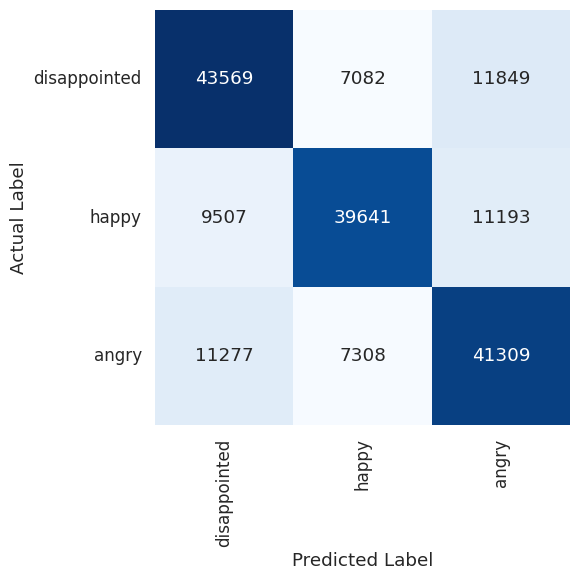

In [39]:
eval_functions.plot_confusion_matrix(actual,predicted,["disappointed","happy","angry"])

In [40]:
actual, predicted = eval_functions.get_actual_predicted_labels(rnn_model, test)
precision, recall, f1_score, perf_metric = eval_functions.calculate_classification_metrics(actual, predicted, [0, 1, 2])
precision, recall, f1_score, perf_metric

714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


({0: 0.7475155997226716, 1: 0.7431841797100494, 2: 0.6989402854077951},
 {0: 0.724528, 1: 0.746755937090867, 2: 0.7179851070224063},
 {0: 0.7358423113797753, 1: 0.7449657772046425, 2: 0.7083347059792456},
 {'avg_precision': 0.7298800216135053,
  'avg_recall': 0.7297563480377577,
  'avg_f1_score': 0.7297142648545544})

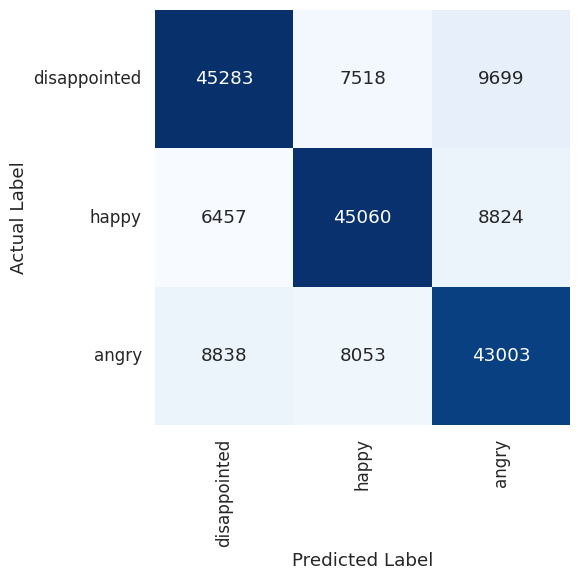

In [41]:
eval_functions.plot_confusion_matrix(actual,predicted,["disappointed","happy","angry"])